# Profiling skforecast

This document shows the profiling of the main classes, methods and functions available in skforecast. Understanding the bottlenecks will help to:

+ Use it more efficiently
+ Improve the code for future releases

## Libraries and data

In [2]:
# Libraries
# ==============================================================================
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
import psutil

import sklearn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster

%load_ext pyinstrument

In [3]:
# Versions
# ==============================================================================
print(f"Python version      : {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version  : {skforecast.__version__}")
print(f"pandas version      : {pd.__version__}")
print(f"numpy version       : {np.__version__}")
print(f"psutil version      : {psutil.__version__}")
print("")

# System information
# ==============================================================================
print(f"Machine type: {platform.machine()}")
print(f"Processor type: {platform.processor()}")
print(f"Platform type: {platform.platform()}")
print(f"Operating system: {platform.system()}")
print(f"Operating system release: {platform.release()}")
print(f"Operating system version: {platform.version()}")
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version      : 3.13.9
scikit-learn version: 1.7.2
skforecast version  : 0.19.0
pandas version      : 2.3.3
numpy version       : 2.2.6
psutil version      : 7.0.0

Machine type: x86_64
Processor type: x86_64
Platform type: Linux-6.14.0-35-generic-x86_64-with-glibc2.39
Operating system: Linux
Operating system release: 6.14.0-35-generic
Operating system version: #35~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Oct 14 13:55:17 UTC 2
Number of physical cores: 4
Number of logical cores: 8


A time series of length 1000 with random values is created.

In [4]:
# Data
# ==============================================================================
np.random.seed(123)
n = 1_000
data = pd.Series(data = np.random.normal(size=n))

## Dummy estimator

To isolate the training process of the estimator from the other parts of the code, a dummy estimator class is created. This dummy estimator has a fit method that does nothing, and a predict method that returns a constant value.

In [5]:
class DummyRegressor(LinearRegression):
    """
    Dummy estimator with dummy fit and predict methods.
    """
    
    def fit(self, X, y):
        pass

    def predict(self, y):
        predictions = np.ones(shape = len(y))
        return predictions

## Profiling fit

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:40:20  Samples:  4
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.009     CPU time: 0.009
/   _/                      v5.1.1

Cell [6]

0.008 <module>  /tmp/ipykernel_26803/930535467.py:1
`- 0.008 ForecasterRecursive.fit  skforecast/recursive/_forecaster_recursive.py:955
      [18 frames hidden]  skforecast, pandas, numpy
         0.002 maybe_infer_to_datetimelike  pandas/core/dtypes/cast.py:1166
         0.002 ufunc.reduce  <built-in>
         0.002 maybe_infer_to_datetimelike  pandas/core/dtypes/cast.py:1166
         0.002 _grouping_func  pandas/core/internals/managers.py:2196
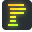

In [6]:
%%pyinstrument

forecaster = ForecasterRecursive(
                 estimator = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

Almost all of the time spent by `fit` is required by the `create_train_X_y` method.

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:40:20  Samples:  66
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.185     CPU time: 0.499
/   _/                      v5.1.1

Cell [7]

0.184 <module>  /tmp/ipykernel_26803/2499331845.py:1
`- 0.183 ForecasterRecursive.fit  skforecast/recursive/_forecaster_recursive.py:955
      [131 frames hidden]  sklearn, joblib, multiprocessing, <bu...
         0.055 sleep  <built-in>
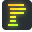

In [7]:
%%pyinstrument

forecaster = ForecasterRecursive(
                 estimator = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

When training a forecaster with a real machine learning estimator, the time spent by `create_train_X_y` is negligible compared to the time needed by the `fit` method of the estimator. Therefore, improving the speed of `create_train_X_y` will not have much impact.

## Profiling create_train_X_y

Understand how the `create_train_X_y` method is influenced by the length of the series and the number of lags. 

In [8]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    execution_time = []
    forecaster = ForecasterRecursive(
                     estimator = DummyRegressor(),
                     lags      = lags
                 )

    for n in series_length:
        y = pd.Series(data = np.random.normal(size=n))
        tic = time.perf_counter()
        _ = forecaster.create_train_X_y(y=y)
        toc = time.perf_counter()
        execution_time.append(toc - tic)

    results[lags] = execution_time

results = pd.DataFrame(
              data = results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.001394,0.000881,0.001552,0.011466,0.010749
250750,0.012573,0.003624,0.027695,0.040414,0.077589
500500,0.018805,0.016675,0.061571,0.095223,0.188530
750250,0.017451,0.021511,0.097587,0.427495,1.073105
1000000,0.016540,0.026660,0.608907,0.585123,2.078700


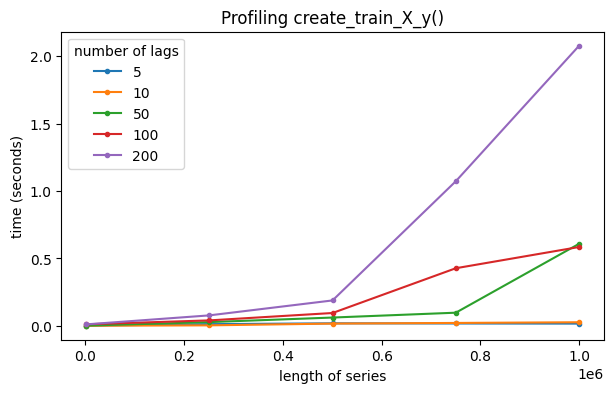

In [9]:
fig, ax = plt.subplots(figsize=(7, 4))
results.plot(ax=ax, marker='.')
ax.set_xlabel('length of series')
ax.set_ylabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title='number of lags');

## Profiling predict

In [10]:
forecaster = ForecasterRecursive(
                 estimator = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:40:27  Samples:  15
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.081     CPU time: 0.079
/   _/                      v5.1.1

Cell [11]

0.080 <module>  /tmp/ipykernel_26803/3639615597.py:1
|- 0.053 [self]  /tmp/ipykernel_26803/3639615597.py
`- 0.027 ForecasterRecursive.predict  skforecast/recursive/_forecaster_recursive.py:1490
      [4 frames hidden]  skforecast, <built-in>
         0.026 ForecasterRecursive._recursive_predict  skforecast/recursive/_forecaster_recursive.py:1287
         `- 0.008 DummyRegressor.predict  /tmp/ipykernel_26803/4114816888.py:9
            |- 0.004 ones  numpy/_core/numeric.py:137
            |     [2 frames hidden]  numpy
            `- 0.004 [self]  /tmp/ipykernel_26803/4114816888.py
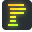

In [11]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

In [12]:
forecaster = ForecasterRecursive(
                 estimator = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:40:27  Samples:  455
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.931     CPU time: 3.676
/   _/                      v5.1.1

Cell [13]

0.928 <module>  /tmp/ipykernel_26803/3639615597.py:1
`- 0.928 ForecasterRecursive.predict  skforecast/recursive/_forecaster_recursive.py:1490
      [46 frames hidden]  skforecast, sklearn, <built-in>, nump...
         0.289 TreePredictor.predict  sklearn/ensemble/_hist_gradient_boosting/predictor.py:46
         `- 0.277 [self]  sklearn/ensemble/_hist_gradient_boosting/predictor.py
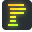

In [13]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

Inside the `predict` method, the `append` action is the most expensive but, similar to what happen with `fit`, it is negligible compared to the time need by the `predict` method of the estimator.